<a href="https://colab.research.google.com/github/anjali-ojha/deep-learning/blob/main/assignment/assignment-4/part1/Anjali_Ojha_HW_4_Part1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 04 - Transfer Learning and Bounding Boxes and YOLOV8

# Part1: Using available pre-trained models for object detection, conduct inference on a short video (5-10 seconds) of a street scene drawing bounding boxes around detected vehicles.

## Use either Pytorch or Tensorflow. Upload a .zip file containing your .ipynb notebook containing the code utilized and two video files: before inference (without bounding boxes) and after inference (with bounding boxes



In [1]:
import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

tf.get_logger().setLevel('ERROR')

In [2]:
ALL_MODELS = {
'CenterNet HourGlass104 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1',
'CenterNet HourGlass104 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1',
'CenterNet HourGlass104 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024/1',
'CenterNet HourGlass104 Keypoints 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024_kpts/1',
'CenterNet Resnet50 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512/1',
'CenterNet Resnet50 V1 FPN Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512_kpts/1',
'CenterNet Resnet101 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet101v1_fpn_512x512/1',
'CenterNet Resnet50 V2 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512/1',
'CenterNet Resnet50 V2 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512_kpts/1',
'EfficientDet D0 512x512' : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
'EfficientDet D1 640x640' : 'https://tfhub.dev/tensorflow/efficientdet/d1/1',
'EfficientDet D2 768x768' : 'https://tfhub.dev/tensorflow/efficientdet/d2/1',
'EfficientDet D3 896x896' : 'https://tfhub.dev/tensorflow/efficientdet/d3/1',
'EfficientDet D4 1024x1024' : 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
'EfficientDet D5 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d5/1',
'EfficientDet D6 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d6/1',
'EfficientDet D7 1536x1536' : 'https://tfhub.dev/tensorflow/efficientdet/d7/1',
'SSD MobileNet v2 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2',
'SSD MobileNet V1 FPN 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1',
'SSD MobileNet V2 FPNLite 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1',
'SSD MobileNet V2 FPNLite 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1',
'SSD ResNet50 V1 FPN 640x640 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1',
'SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_1024x1024/1',
'SSD ResNet101 V1 FPN 640x640 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1',
'SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_1024x1024/1',
'SSD ResNet152 V1 FPN 640x640 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_640x640/1',
'SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_1024x1024/1',
'Faster R-CNN ResNet50 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1',
'Faster R-CNN ResNet50 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1',
'Faster R-CNN ResNet50 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_800x1333/1',
'Faster R-CNN ResNet101 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1',
'Faster R-CNN ResNet101 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_1024x1024/1',
'Faster R-CNN ResNet101 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_800x1333/1',
'Faster R-CNN ResNet152 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_640x640/1',
'Faster R-CNN ResNet152 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_1024x1024/1',
'Faster R-CNN ResNet152 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_800x1333/1',
'Faster R-CNN Inception ResNet V2 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1',
'Faster R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1',
'Mask R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'
}

In [3]:
%%bash
git clone --depth 1 https://github.com/tensorflow/models
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .


Reading package lists...
Building dependency tree...
Reading state information...
protobuf-compiler is already the newest version (3.12.4-1ubuntu7.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Processing /content/models/research
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing met

Cloning into 'models'...
Updating files: 100% (3696/3696), done.




In [4]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

In [5]:
PATH_TO_LABELS = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [6]:
#@title Model Selection { display-mode: "form", run: "auto" }
model_display_name = 'Faster R-CNN ResNet50 V1 640x640' # @param ['CenterNet HourGlass104 512x512','CenterNet HourGlass104 Keypoints 512x512','CenterNet HourGlass104 1024x1024','CenterNet HourGlass104 Keypoints 1024x1024','CenterNet Resnet50 V1 FPN 512x512','CenterNet Resnet50 V1 FPN Keypoints 512x512','CenterNet Resnet101 V1 FPN 512x512','CenterNet Resnet50 V2 512x512','CenterNet Resnet50 V2 Keypoints 512x512','EfficientDet D0 512x512','EfficientDet D1 640x640','EfficientDet D2 768x768','EfficientDet D3 896x896','EfficientDet D4 1024x1024','EfficientDet D5 1280x1280','EfficientDet D6 1280x1280','EfficientDet D7 1536x1536','SSD MobileNet v2 320x320','SSD MobileNet V1 FPN 640x640','SSD MobileNet V2 FPNLite 320x320','SSD MobileNet V2 FPNLite 640x640','SSD ResNet50 V1 FPN 640x640 (RetinaNet50)','SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)','SSD ResNet101 V1 FPN 640x640 (RetinaNet101)','SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)','SSD ResNet152 V1 FPN 640x640 (RetinaNet152)','SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)','Faster R-CNN ResNet50 V1 640x640','Faster R-CNN ResNet50 V1 1024x1024','Faster R-CNN ResNet50 V1 800x1333','Faster R-CNN ResNet101 V1 640x640','Faster R-CNN ResNet101 V1 1024x1024','Faster R-CNN ResNet101 V1 800x1333','Faster R-CNN ResNet152 V1 640x640','Faster R-CNN ResNet152 V1 1024x1024','Faster R-CNN ResNet152 V1 800x1333','Faster R-CNN Inception ResNet V2 640x640','Faster R-CNN Inception ResNet V2 1024x1024','Mask R-CNN Inception ResNet V2 1024x1024']
model_handle = ALL_MODELS[model_display_name]

print('Selected model:'+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))

Selected model:Faster R-CNN ResNet50 V1 640x640
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1


In [7]:
! pip install opencv-python==4.9.0.80

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 8.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.8.0.76
    Uninstalling opencv-python-4.8.0.76:
      Successfully uninstalled opencv-python-4.8.0.76


## Step 1. Collect a source video. It may be necessary to divide the video into discrete image frames.


In [21]:
! rm -rf input_video.mp4*
! wget https://github.com/anjali-ojha/deep-learning/raw/main/assignment/assignment-4/part1/input_video.mp4

--2024-02-29 03:37:36--  https://github.com/anjali-ojha/deep-learning/raw/main/assignment/assignment-4/part1/input_video.mp4
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/anjali-ojha/deep-learning/main/assignment/assignment-4/part1/input_video.mp4 [following]
--2024-02-29 03:37:36--  https://raw.githubusercontent.com/anjali-ojha/deep-learning/main/assignment/assignment-4/part1/input_video.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 532974 (520K) [application/octet-stream]
Saving to: ‘input_video.mp4’

input_video.mp4     100%[===================>] 520.48K  --.-KB/s    in 0.02s   



In [9]:
# Define input and output directories
import os
HOME = os.getcwd()
print(HOME)
input_frames_folder = f'{HOME}/input_frames'
output_frames_folder = f'{HOME}/output_frames'

/content


In [22]:
import cv2

def extract_frames(video_path, input_frames_folder):

    if not os.path.exists(input_frames_folder):
        os.makedirs(input_frames_folder)

    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Read and save frames until the video ends
    frame_count = 0
    while True:
        ret, frame = cap.read()
        # print(ret, frame)
        if not ret:
            break

        # Save the frame
        frame_count += 1
        frame_path = f"{input_frames_folder}/frame_{frame_count:04d}.jpg"
        cv2.imwrite(frame_path, frame)

        if frame_count%10 == 0:
            print(f"Frame {frame_count} saved as {frame_path}")

    cap.release()

# ! wget https://github.com/anjali-ojha/deep-learning/blob/main/assignment/assignment-4/video.mp4
# Example usage
video_path = f"{HOME}/input_video.mp4"
extract_frames(video_path, input_frames_folder)

Frame 10 saved as /content/input_frames/frame_0010.jpg
Frame 20 saved as /content/input_frames/frame_0020.jpg
Frame 30 saved as /content/input_frames/frame_0030.jpg
Frame 40 saved as /content/input_frames/frame_0040.jpg
Frame 50 saved as /content/input_frames/frame_0050.jpg
Frame 60 saved as /content/input_frames/frame_0060.jpg
Frame 70 saved as /content/input_frames/frame_0070.jpg
Frame 80 saved as /content/input_frames/frame_0080.jpg
Frame 90 saved as /content/input_frames/frame_0090.jpg
Frame 100 saved as /content/input_frames/frame_0100.jpg
Frame 110 saved as /content/input_frames/frame_0110.jpg
Frame 120 saved as /content/input_frames/frame_0120.jpg
Frame 130 saved as /content/input_frames/frame_0130.jpg
Frame 140 saved as /content/input_frames/frame_0140.jpg
Frame 150 saved as /content/input_frames/frame_0150.jpg
Frame 160 saved as /content/input_frames/frame_0160.jpg
Frame 170 saved as /content/input_frames/frame_0170.jpg


## Step 2. Conduct inference on each frame of the video, drawing bounding boxes around detected vehicles.


In [25]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: the file path to the image

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """
    image = None
    if(path.startswith('http')):
        response = urlopen(path)
        image_data = response.read()
        image_data = BytesIO(image_data)
        image = Image.open(image_data)
    else:
        image_data = tf.io.gfile.GFile(path, 'rb').read()
        image = Image.open(BytesIO(image_data))

    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
      (1, im_height, im_width, 3)).astype(np.uint8)



In [14]:
#@title Model Selection { display-mode: "form", run: "auto" }
model_display_name = 'Faster R-CNN ResNet152 V1 640x640' # @param ['CenterNet HourGlass104 512x512','CenterNet HourGlass104 Keypoints 512x512','CenterNet HourGlass104 1024x1024','CenterNet HourGlass104 Keypoints 1024x1024','CenterNet Resnet50 V1 FPN 512x512','CenterNet Resnet50 V1 FPN Keypoints 512x512','CenterNet Resnet101 V1 FPN 512x512','CenterNet Resnet50 V2 512x512','CenterNet Resnet50 V2 Keypoints 512x512','EfficientDet D0 512x512','EfficientDet D1 640x640','EfficientDet D2 768x768','EfficientDet D3 896x896','EfficientDet D4 1024x1024','EfficientDet D5 1280x1280','EfficientDet D6 1280x1280','EfficientDet D7 1536x1536','SSD MobileNet v2 320x320','SSD MobileNet V1 FPN 640x640','SSD MobileNet V2 FPNLite 320x320','SSD MobileNet V2 FPNLite 640x640','SSD ResNet50 V1 FPN 640x640 (RetinaNet50)','SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)','SSD ResNet101 V1 FPN 640x640 (RetinaNet101)','SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)','SSD ResNet152 V1 FPN 640x640 (RetinaNet152)','SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)','Faster R-CNN ResNet50 V1 640x640','Faster R-CNN ResNet50 V1 1024x1024','Faster R-CNN ResNet50 V1 800x1333','Faster R-CNN ResNet101 V1 640x640','Faster R-CNN ResNet101 V1 1024x1024','Faster R-CNN ResNet101 V1 800x1333','Faster R-CNN ResNet152 V1 640x640','Faster R-CNN ResNet152 V1 1024x1024','Faster R-CNN ResNet152 V1 800x1333','Faster R-CNN Inception ResNet V2 640x640','Faster R-CNN Inception ResNet V2 1024x1024','Mask R-CNN Inception ResNet V2 1024x1024']
model_handle = ALL_MODELS[model_display_name]

print('Selected model:'+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))


Selected model:Faster R-CNN ResNet152 V1 640x640
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_640x640/1


In [15]:
print('loading model...')
hub_model = hub.load(model_handle)
print('model loaded!')

loading model...
model loaded!


In [28]:
def predict(image_np):
    # running inference
    results = hub_model(image_np)

    # different object detection models have additional results
    # all of them are explained in the documentation
    result = {key:value.numpy() for key,value in results.items()}
    # print(result.keys())

    label_id_offset = 0
    image_np_with_detections = image_np.copy()

    # Filter detections to only include vehicles (assuming vehicles have class ID 3)
    vehicle_indices = np.where(result['detection_classes'][0] == 3)[0]
    vehicle_boxes = result['detection_boxes'][0][vehicle_indices]
    vehicle_scores = result['detection_scores'][0][vehicle_indices]
    class_labels = ['vehicle' for _ in vehicle_indices]

    # print(vehicle_scores)
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections[0],
        vehicle_boxes,
        np.ones_like(vehicle_indices) * 3,  # Class ID for vehicles
        vehicle_scores,
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.30,  # Adjust this threshold as needed
        agnostic_mode=False,
    )
    return image_np_with_detections[0]


def show_image(image):
    plt.figure(figsize=(24,32))
    plt.imshow(image)
    plt.show()


/content/input_frames/frame_0001.jpg
(1, 360, 640, 3)
Processed /content/input_frames/frame_0001.jpg and wrote to /content/output_frames/frame_0001.jpg


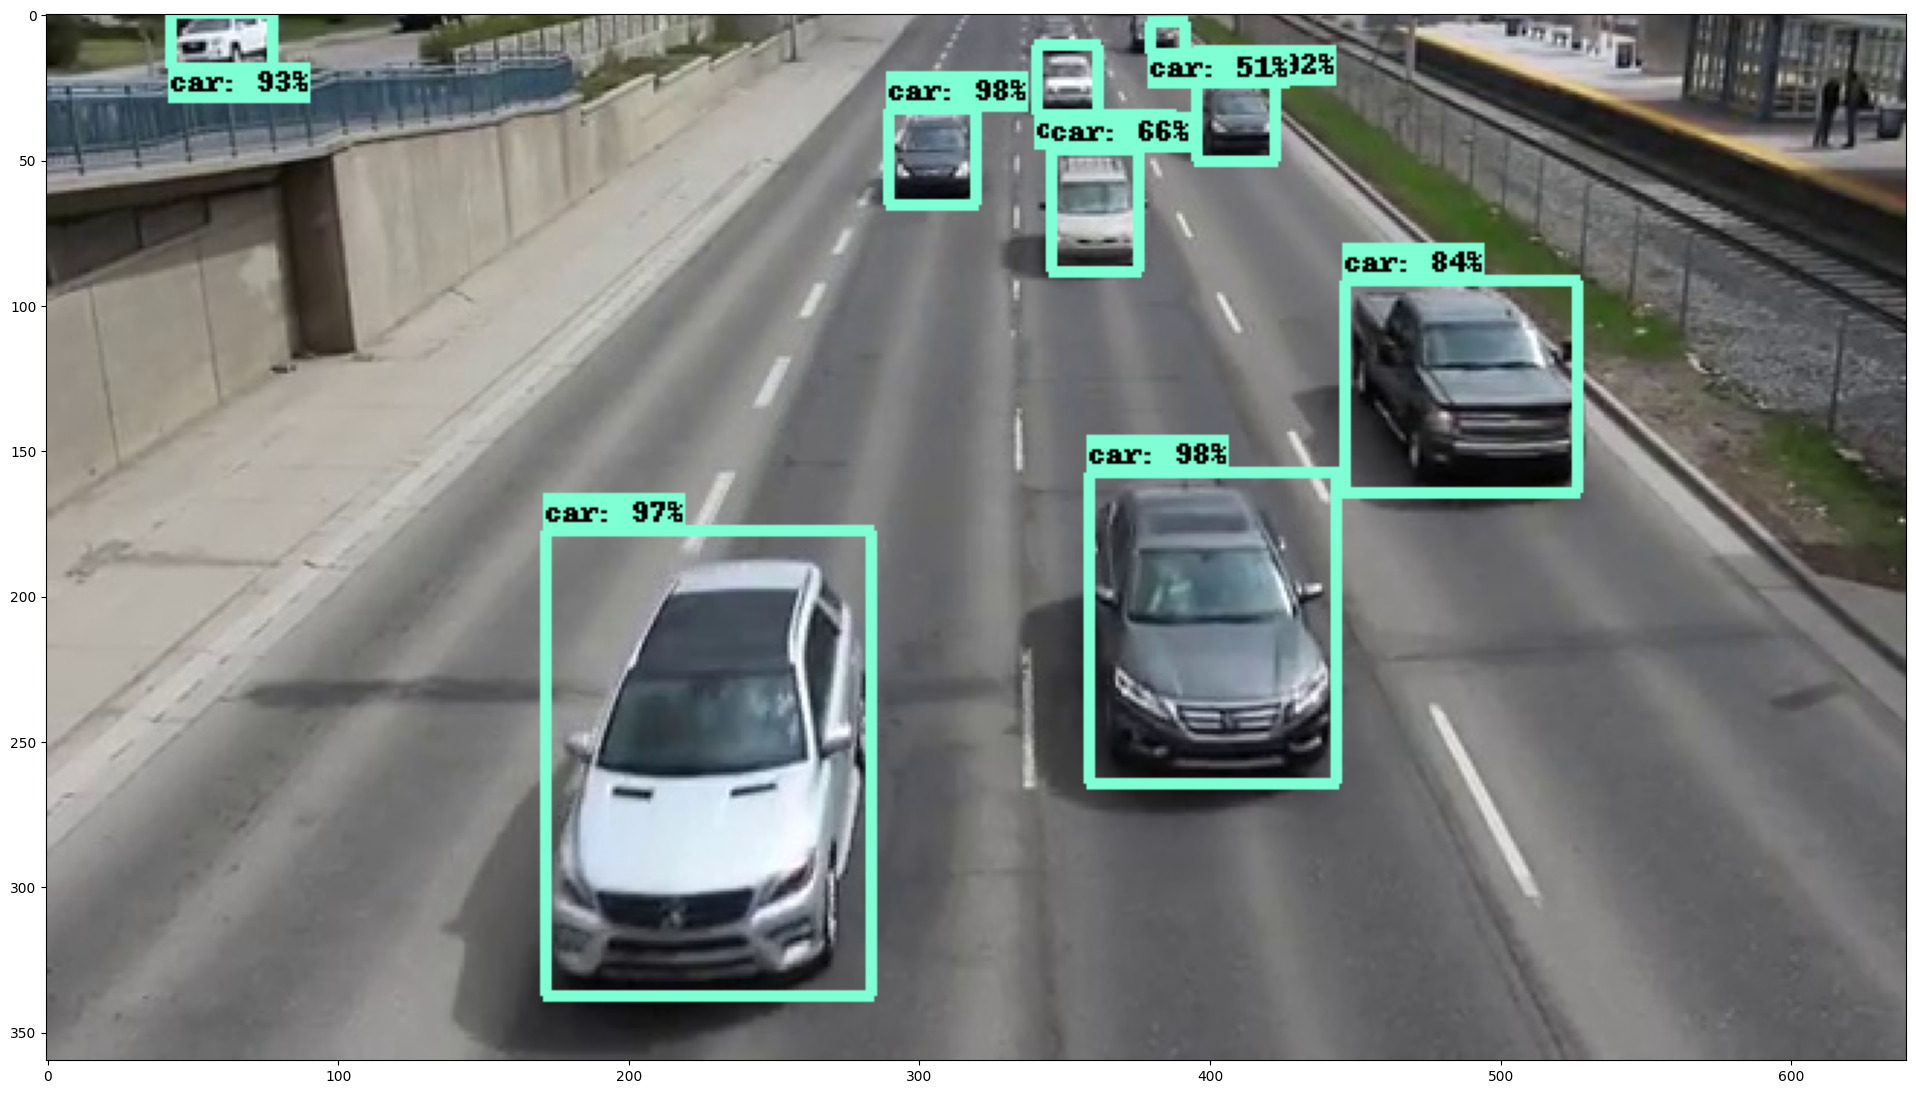

/content/input_frames/frame_0002.jpg
(1, 360, 640, 3)
Processed /content/input_frames/frame_0002.jpg and wrote to /content/output_frames/frame_0002.jpg
/content/input_frames/frame_0003.jpg
(1, 360, 640, 3)
Processed /content/input_frames/frame_0003.jpg and wrote to /content/output_frames/frame_0003.jpg
/content/input_frames/frame_0004.jpg
(1, 360, 640, 3)
Processed /content/input_frames/frame_0004.jpg and wrote to /content/output_frames/frame_0004.jpg
/content/input_frames/frame_0005.jpg
(1, 360, 640, 3)
Processed /content/input_frames/frame_0005.jpg and wrote to /content/output_frames/frame_0005.jpg
/content/input_frames/frame_0006.jpg
(1, 360, 640, 3)
Processed /content/input_frames/frame_0006.jpg and wrote to /content/output_frames/frame_0006.jpg
/content/input_frames/frame_0007.jpg
(1, 360, 640, 3)
Processed /content/input_frames/frame_0007.jpg and wrote to /content/output_frames/frame_0007.jpg
/content/input_frames/frame_0008.jpg
(1, 360, 640, 3)
Processed /content/input_frames/fr

In [29]:
import os
import shutil


# Create output folder if it doesn't exist
if not os.path.exists(output_frames_folder):
    os.makedirs(output_frames_folder)

i = 0
# Iterate over files in the input folder
for filename in sorted(os.listdir(input_frames_folder)):
    input_file_path = f'{input_frames_folder}/{filename}'
    output_file_path = f"{output_frames_folder}/{filename}"
    print(input_file_path)

    i += 1
    # if i%10 != 1:
    #     continue

    if filename.endswith('.jpg'):  # Process only text files, adjust as needed
        # Read content from input file
        img = load_image_into_numpy_array(input_file_path)
        # print(img.shape)
        tagged_img = predict(img)

        # Convert the NumPy array to a PIL image
        image = Image.fromarray(tagged_img)

        # Save the image as a JPEG file
        image.save(output_file_path)

        print(f"Processed {input_file_path} and wrote to {output_file_path}")

        if i == 1:
            show_image(tagged_img)



print("Processing complete.")


## Step 3. Format the results back into a video.


In [30]:
def images_to_video(image_folder, output_video_path, fps=30):
    """
    This method reads images from the folder and stitch them in a video.
    All the images have ordering number associated with them to keep the
    frames in sync.
    """
    # Get list of image files in the folder
    image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.jpg')]

    # Sort the image files based on their names
    image_files.sort()

    # Read the first image to get dimensions
    img = cv2.imread(image_files[0])
    height, width, _ = img.shape

    # Create video writer object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Specify the codec
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    # Writing frames to video.
    for image_file in image_files:
        img = cv2.imread(image_file)
        out.write(img)

    out.release()

In [31]:
# Example usage
output_video_path = f"{HOME}/output_video.mp4"
images_to_video(output_frames_folder, output_video_path)

## Summary - This code takes input file = input_video.mp4 and generate output_video.mp4, which highlights all vehicles detected with teal color boundary box.